# <div align="center">Dealing with Imbalanced Data</div>
---------------------------------------------------------------------

you can Find me on Github:
> ###### [ GitHub](https://github.com/lev1khachatryan)

<img src="asset/main.jpg" />

Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of observations in each class. Class imbalance can be found in many different areas including medical diagnosis, spam filtering, and fraud detection.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score,balanced_accuracy_score


users = pd.read_csv('input/All_Users.csv')
KPIs = pd.read_csv('input/KPIs_2&3.csv')

Activities = pd.merge(users, KPIs)
Activities.fillna(0, inplace =True)
Activities['Learn'] = Activities.L + Activities.UL
Activities['Social_1'] = Activities.UC + Activities.UP + Activities.DP
Activities['Social_2'] = Activities.CP + Activities.P + Activities.OP



Checkins = pd.read_csv('input/Checkins_4,5&6.csv')
retained_activities = pd.read_csv('input/KPIs_4,5&6.csv')

Retention = pd.merge(pd.merge(users, Checkins, how = 'left'), retained_activities)
Retention.fillna(0, inplace =True)
Retention['Learn'] = Retention.L + Retention.UL
Retention['Social_1'] = Retention.UC + Retention.UP + Retention.DP
Retention['Social_2'] = Retention.CP + Retention.P + Retention.OP
Retention['Total'] = Retention.Learn + Retention.Social_1 + Retention.Social_2
Retention['y'] = np.where((Retention.NofCheckins > 0) & (Retention.Total >= 3) & (Retention.Learn >= 0) & (Retention.Social_1 >= 0), 1 , 0)


# columns to use
X_col = ['UC', 'UP', 'DP', 'CP', 'L', 'UL', 'P', 'OP', 'F']
# X_col = ['Learn', 'Social_1', 'Social_2']

y_col = 'y'

X = Activities[X_col]
y = Retention[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) # 75% training and 25% test


print('The percentage of negative class is: {}'.format((y[y == 0].shape[0] / y.shape[0])* 100))
print('The percentage of positive class is: {}'.format((y[y == 1].shape[0] / y.shape[0])* 100))


The percentage of negative class is: 85.04514576798779
The percentage of positive class is: 14.954854232012208


### Our objective will be to correctly classify the minority class.

# <div align="center">The Problem with Imbalanced Classes</div>
---------------------------------------------------------------------
Most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce error.

### The Problem with Accuracy
Here we can use the DummyClassifier to always predict “not fraud” just to show how misleading accuracy can be.

In [35]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0]
Test score:  0.8508376660889659


We got an accuracy score of 85.08% — And without even training a model! Let’s compare this to logistic regression, an actual trained classifier.

In [36]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

# Checking accuracy
print('Accuracy: ', accuracy_score(y_test, lr_pred))

# Checking unique values
predictions = pd.DataFrame(lr_pred)
print(predictions[0].value_counts())

Accuracy:  0.8626635402861318
0    142939
1      4196
Name: 0, dtype: int64


### Let’s take a look at some popular methods for dealing with class imbalance.

# <div align="center">1. Change the performance metric</div>
---------------------------------------------------------------------

As we saw above, accuracy is not the best metric to use when evaluating imbalanced datasets as it can be very misleading. 


Metrics that can provide better insight include:

* Confusion Matrix: a table showing correct predictions and types of incorrect predictions.


* Precision: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.


* Recall: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.


* F1: Score: the weighted average of precision and recall.


Let’s see what happens when we apply these F1 and recall scores to our logistic regression from above.

In [37]:
# f1 score
print(f1_score(y_test, lr_pred))

# recall score
print(recall_score(y_test, lr_pred))

0.2270588685307731
0.1352348840388208


These scores don’t look quite so impressive. Let’s see what other methods we might try to improve our new metrics.

# <div align="center">2. Change the algorithm</div>
---------------------------------------------------------------------

While in every machine learning problem, it’s a good rule of thumb to try a variety of algorithms, it can be especially beneficial with imbalanced datasets. Decision trees frequently perform well on imbalanced data. They work by learning a hierarchy of if/else questions and this can force both classes to be addressed.

In [38]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, rfc_pred))

print('F1 Score: ', f1_score(y_test, rfc_pred))

print('Recall: ', recall_score(y_test, rfc_pred))

Accuracy:  0.8593468583273864
F1 Score:  0.31602604356016784
Recall:  0.21784298537385519


While our accuracy score is slightly lower, both F1 and recall have increased as compared to logistic regression! It appears that for this specific problem, random forest may be a better choice of model.

# <div align="center">3. Resampling Techniques — Oversample minority class</div>
---------------------------------------------------------------------

Our next method begins our resampling techniques.

Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.

We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

### Important Note
Always split into test and train sets BEFORE trying oversampling techniques! Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets. This can allow our model to simply memorize specific data points and cause overfitting and poor generalization to the test data.

In [39]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
negative_class = X[X.y==0]
positive_class = X[X.y==1]

# upsample minority
positive_class_upsampled = resample(positive_class,
                          replace=True, # sample with replacement
                          n_samples=len(negative_class), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([negative_class, positive_class_upsampled])

# check new class counts
upsampled.y.value_counts()

1    375335
0    375335
Name: y, dtype: int64

After resampling we have an equal ratio of data points for each class! Let’s try our logistic regression again with the balanced training data.

In [40]:
# trying logistic regression again with the balanced dataset
# y_train = upsampled.y
# X_train = upsampled.drop('y', axis=1)

upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, upsampled_pred))

print('F1 Score: ', f1_score(y_test, upsampled_pred))

print('Recall: ', recall_score(y_test, upsampled_pred))

print('Precision: ', precision_score(y_test, upsampled_pred))

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, upsampled_pred))


Accuracy:  0.8626635402861318
F1 Score:  0.2270588685307731
Recall:  0.1352348840388208
Precision:  0.7073403241182078
Balanced Accuracy:  0.5627128185730738


# <div align="center">4. Resampling techniques — Undersample majority class</div>
---------------------------------------------------------------------

Undersampling can be defined as removing some observations of the majority class. Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set.

We will again use the resampling module from Scikit-Learn to randomly remove samples from the majority class.

In [41]:
# still using our separated classes fraud and not_fraud from above

# downsample majority
negative_class_downsampled = resample(negative_class,
                                replace = False, # sample without replacement
                                n_samples = len(positive_class), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([negative_class_downsampled, positive_class])

# checking counts
downsampled.y.value_counts()

1    66068
0    66068
Name: y, dtype: int64

In [42]:
# trying logistic regression again with the undersampled dataset

# y_train = downsampled.y
# X_train = downsampled.drop('y', axis=1)

undersampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

undersampled_pred = undersampled.predict(X_test)

# Checking accuracy
print('Accuracy: ', accuracy_score(y_test, undersampled_pred))

# f1 score
print('F1 Score: ', f1_score(y_test, undersampled_pred))

print('Recall: ', recall_score(y_test, undersampled_pred))

print('Precision: ', precision_score(y_test, undersampled_pred))

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, undersampled_pred))


Accuracy:  0.8626635402861318
F1 Score:  0.2270588685307731
Recall:  0.1352348840388208
Precision:  0.7073403241182078
Balanced Accuracy:  0.5627128185730738


# <div align="center">5. Generate synthetic samples</div>
---------------------------------------------------------------------

A technique similar to upsampling is to create synthetic samples. Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.

Again, it’s important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.

In [43]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 42, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

After generating our synthetic data points, let’s see how our logistic regression performs

In [44]:
smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)

smote_pred = smote.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, smote_pred))

print('F1 Score: ', f1_score(y_test, smote_pred))

print('Recall: ', recall_score(y_test, smote_pred))

print('Precision: ', precision_score(y_test, smote_pred))

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, smote_pred))

Accuracy:  0.8497366364223332
F1 Score:  0.44995646224654806
Recall:  0.41203809176652845
Precision:  0.49556115738711093
Balanced Accuracy:  0.6692543400009113


# <div align="center">6. Decision Tree</div>
---------------------------------------------------------------------


In [45]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 5,
    max_features = 5,
    min_samples_leaf = 10,
    min_samples_split = 0.1)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)


print('Accuracy: ', accuracy_score(y_test, pred))

print('F1 Score: ', f1_score(y_test, pred))

print('Recall: ', recall_score(y_test, pred))

print('Precision: ', precision_score(y_test, pred))

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, pred))

Accuracy:  0.7900091752472219
F1 Score:  0.46334219165233703
Recall:  0.607736820522167
Precision:  0.3743894908213103
Balanced Accuracy:  0.7148502935086791


In [46]:
X_test.columns.values

array(['UC', 'UP', 'DP', 'CP', 'L', 'UL', 'P', 'OP', 'F'], dtype=object)

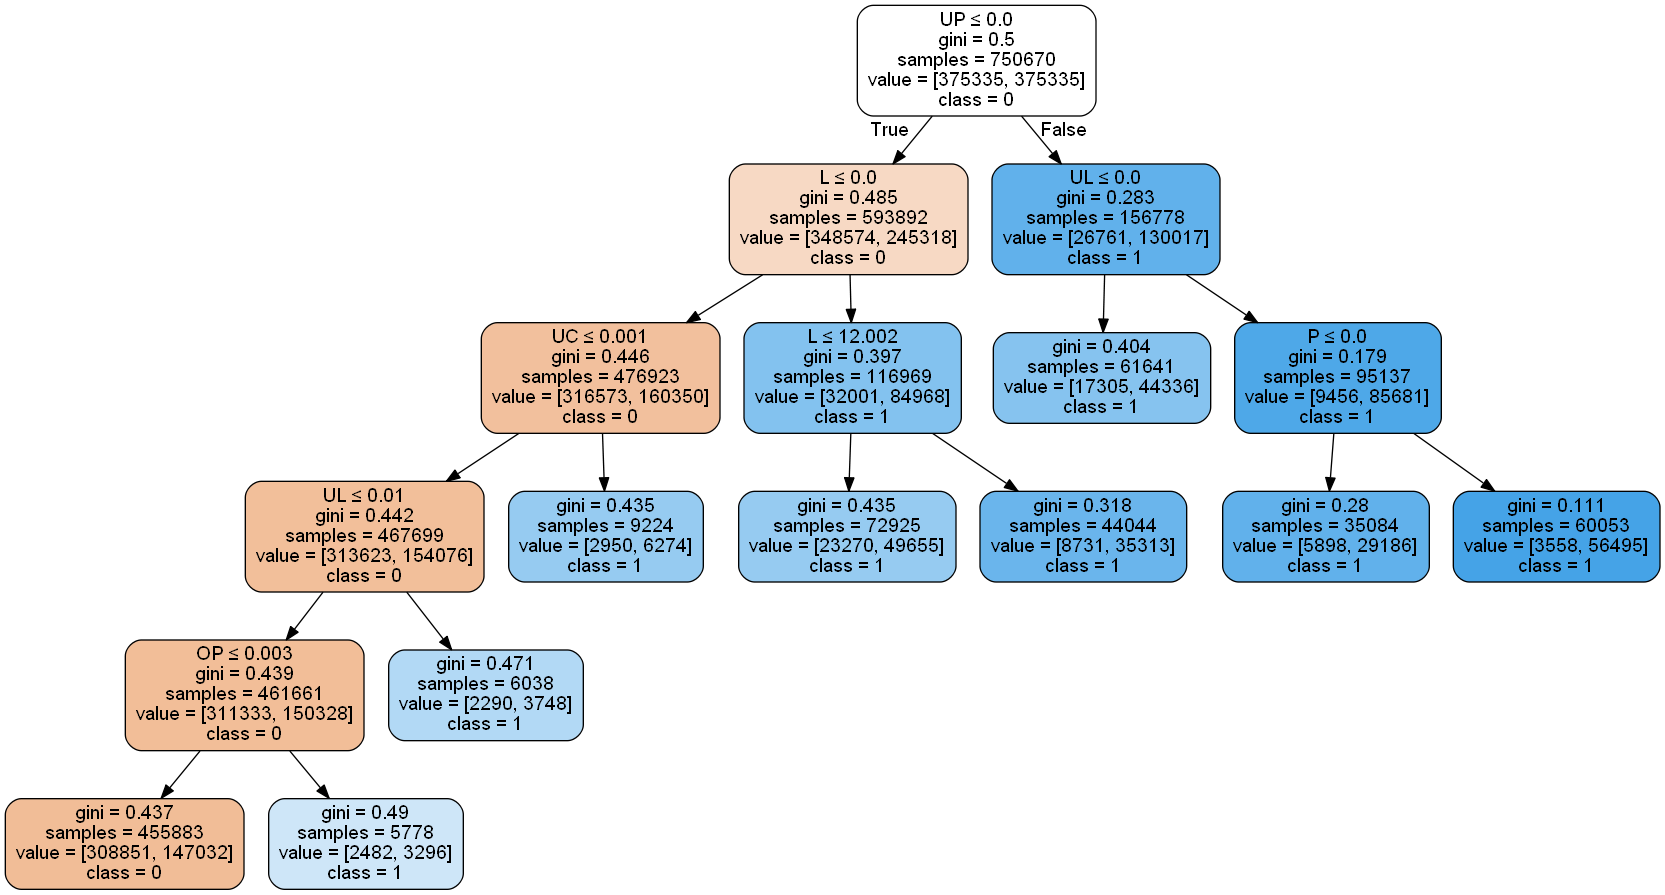

In [47]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()

export_graphviz(clf, 
                out_file = dot_data,  
                filled = True, 
                rounded = True,
                special_characters = True, 
                feature_names = X_test.columns.values, 
                class_names=['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  


# graph.write_png('UserActivity_2.png')

Image(graph.create_png())

# <div align="center">7. Random Forest</div>
---------------------------------------------------------------------

In [48]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=8, criterion='entropy')

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)


print('Accuracy: ', accuracy_score(y_test, pred))

print('F1 Score: ', f1_score(y_test, pred))

print('Recall: ', recall_score(y_test, pred))

print('Precision: ', precision_score(y_test, pred))

print('Balanced Accuracy: ', balanced_accuracy_score(y_test, pred))

Accuracy:  0.7888741631834709
F1 Score:  0.46345170650822165
Recall:  0.6112908370164487
Precision:  0.37319536009346577
Balanced Accuracy:  0.7156487734623733


In [23]:
# from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# import pydotplus

# dot_data = StringIO()

# export_graphviz(clf, 
#                 out_file = dot_data,  
#                 filled = True, 
#                 rounded = True,
#                 special_characters = True, 
#                 feature_names = X_test.columns.values, 
#                 class_names=['0','1'])

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  


# graph.write_png('RandomForest_1.png')

# Image(graph.create_png())

# Another approach

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score,balanced_accuracy_score


users = pd.read_csv('input/All_Users.csv')
KPIs = pd.read_csv('input/KPIs_2&3.csv')

Activities = pd.merge(users, KPIs)
Activities.fillna(0, inplace =True)
Activities['Learn'] = Activities.L + Activities.UL
Activities['Social_1'] = Activities.UC + Activities.UP + Activities.DP
Activities['Social_2'] = Activities.CP + Activities.P + Activities.OP


Countries = pd.read_csv('input/Users_Country.csv')
Countries.loc[~Countries['CountryCode'].isin(['IN', 'RU', 'US', 'ID', 'UA', 'MX', 'DE', 'GB']), 'CountryCode'] = 'Other'
Activities = pd.merge(Activities, Countries, left_on='UserId', right_on='UserId')
Activities['CC'] = Activities['CountryCode']


Checkins = pd.read_csv('input/Checkins_4,5&6.csv')
retained_activities = pd.read_csv('input/KPIs_4,5&6.csv')

Retention = pd.merge(pd.merge(users, Checkins, how = 'left'), retained_activities)
Retention.fillna(0, inplace =True)
Retention['Learn'] = Retention.L + Retention.UL
Retention['Social_1'] = Retention.UC + Retention.UP + Retention.DP
Retention['Social_2'] = Retention.CP + Retention.P + Retention.OP
Retention['Total'] = Retention.Learn + Retention.Social_1 + Retention.Social_2
Retention['y'] = np.where((Retention.NofCheckins > 0) & (Retention.Total >= 3) & (Retention.Learn >= 0) & (Retention.Social_1 >= 0), 1 , 0)
Retention = pd.merge(Retention, Countries, left_on='UserId', right_on='UserId')

# columns to use
X_col = ['UC', 'UP', 'DP', 'CP', 'L', 'UL', 'P', 'OP', 'F', 'CC']
# X_col = ['Learn', 'Social_1', 'Social_2']

y_col = 'y'

X = Activities[X_col]
y = Retention[y_col]

X = pd.get_dummies(X, drop_first=True)

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold


sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
#     print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.85045165 0.14954835]
[0.85045792 0.14954208]


In [3]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(random_state = 42, ratio = 1.0)
# X_train, y_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [4]:
# print('# of observations in original train dataset: ', len(original_ytrain))
# print('# of positive classes in original train dataset: ', original_ytrain.sum())
# print('% of positive class in original train dataset: ', original_ytrain.sum()/len(original_ytrain)*100)
# print('-' * 100)
# print('# of observations in SMOTE train dataset: ', len(y_train))
# print('# of positive classes in original train dataset: ', y_train.sum())
# print('% of positive class in original train dataset: ', y_train.sum()/len(y_train)*100)


In [76]:
X_current = pd.concat([pd.DataFrame(original_Xtrain, columns=X.columns), pd.DataFrame(original_ytrain, columns=['y'])], axis=1, )

In [77]:
from sklearn.utils import resample

X_current = pd.concat([pd.DataFrame(original_Xtrain, columns=X.columns), pd.DataFrame(original_ytrain, columns=['y'])], axis=1, )

# separate minority and majority classes
negative_class = X_current[X_current.y==0]
positive_class = X_current[X_current.y==1]

# downsample majority
negative_class_downsampled = resample(negative_class,
                                replace = False, # sample without replacement
                                n_samples = len(positive_class), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([negative_class_downsampled, positive_class])

# checking counts
downsampled.y.value_counts()

1    70412
0    70412
Name: y, dtype: int64

In [78]:
X_train = downsampled.drop(columns=['y'])
y_train = downsampled['y']

y_train = y_train.values
X_train = X_train.values

In [79]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 5,
    max_features = 5,
    min_samples_leaf = 10,
    min_samples_split = 0.1)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
pred = clf.predict(original_Xtest)
pred_prob = clf.predict_proba(original_Xtest)


print('Accuracy: ', accuracy_score(original_ytest, pred))

print('F1 Score: ', f1_score(original_ytest, pred))

print('Recall: ', recall_score(original_ytest, pred))

print('Precision: ', precision_score(original_ytest, pred))

print('Balanced Accuracy: ', balanced_accuracy_score(original_ytest, pred))

Accuracy:  0.7967648208247667
F1 Score:  0.4648322147651006
Recall:  0.5902170207930917
Precision:  0.38338622776588677
Balanced Accuracy:  0.711650306928153


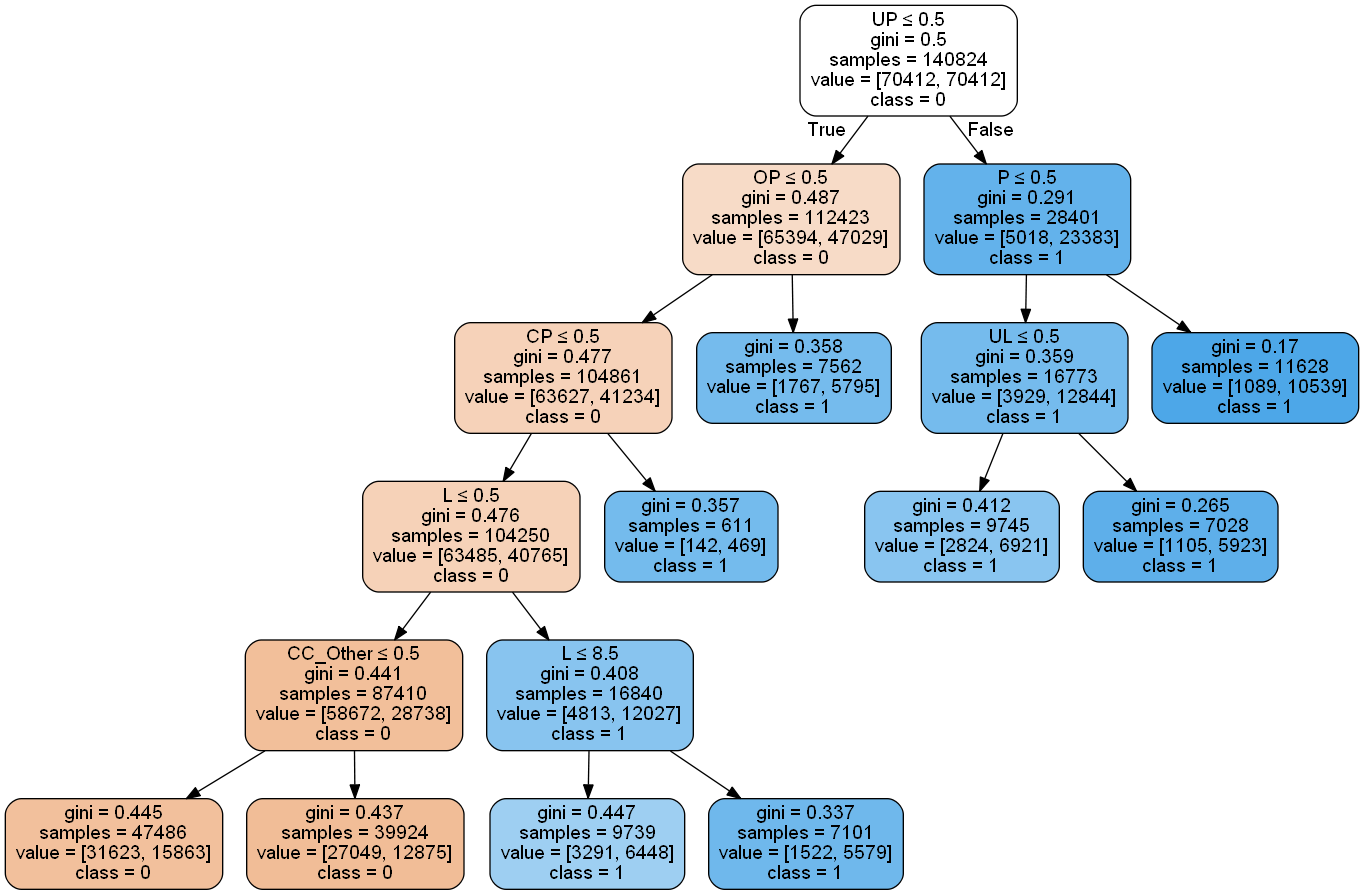

In [80]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()

export_graphviz(clf, 
                out_file = dot_data,  
                filled = True, 
                rounded = True,
                special_characters = True, 
                feature_names = X.columns.values, 
                class_names=['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  


graph.write_png('For_Gagik.png')

Image(graph.create_png())

In [81]:
list(zip(clf.feature_importances_, X.columns.values))

[(0.0, 'UC'),
 (0.519577809952193, 'UP'),
 (0.0, 'DP'),
 (0.012034256442814669, 'CP'),
 (0.3018094277027852, 'L'),
 (0.010024850353198821, 'UL'),
 (0.018964693462497614, 'P'),
 (0.13718341341605103, 'OP'),
 (0.0, 'F'),
 (0.0, 'CC_GB'),
 (0.0, 'CC_ID'),
 (0.0, 'CC_IN'),
 (0.0, 'CC_MX'),
 (0.0004055486704596739, 'CC_Other'),
 (0.0, 'CC_RU'),
 (0.0, 'CC_UA'),
 (0.0, 'CC_US')]

In [85]:
X_train = pd.DataFrame(X_train, columns=X.columns)

In [86]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

X_with_const = sm.add_constant(X_train)
log_reg_stats = sm.OLS(y_train, X_with_const).fit()
print(log_reg_stats.summary())#.tables[0]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     498.2
Date:                Tue, 02 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:45:48   Log-Likelihood:                -98096.
No. Observations:              140824   AIC:                         1.962e+05
Df Residuals:                  140806   BIC:                         1.964e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4860      0.008     62.297      0.0

In [30]:
# # Make sure we use the subsample in our correlation

# f, (ax1) = plt.subplots(1, 1, figsize=(10,5))

# # Entire DataFrame
# corr = X.corr()
# sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1, annot=True, fmt='.1f' )
# ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)
# plt.show();

In [ ]:
# Let's implement simple classifiers
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Classifiers:  LogisticRegression Has a training score of 67.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 66.0 % accuracy score


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
# # Use GridSearchCV to find the best parameters.
# from sklearn.model_selection import GridSearchCV


# # Logistic Regression 
# log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



# grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
# grid_log_reg.fit(X_train, y_train)
# # We automatically get the logistic regression with the best parameters.
# log_reg = grid_log_reg.best_estimator_

# knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
# grid_knears.fit(X_train, y_train)
# # KNears best estimator
# knears_neighbors = grid_knears.best_estimator_

# # Support Vector Classifier
# svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
# grid_svc = GridSearchCV(SVC(), svc_params)
# grid_svc.fit(X_train, y_train)

# # SVC best estimator
# svc = grid_svc.best_estimator_

# # DecisionTree Classifier
# tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
#               "min_samples_leaf": list(range(5,7,1))}
# grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
# grid_tree.fit(X_train, y_train)

# # tree best estimator
# tree_clf = grid_tree.best_estimator_



# # Overfitting Case

# log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
# print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


# knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
# print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

# svc_score = cross_val_score(svc, X_train, y_train, cv=5)
# print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

# tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
# print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')